## Odd Jobs

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(fable))
suppressPackageStartupMessages(library(tsibble))
options(repr.plot.width = 15, repr.plot.height = 8)

add_theme <- function(g){
    return(g+theme_grey(base_size = 22))
}

### 1. Interpolate a timeseries dataframe

In [2]:
(df <- read.csv('./Data/sample_data_resample.csv'))%>%
    head()


,Time,X1,X2
,<fct>,<int>,<int>
1,2012-03-22 08:30:00,14770,0
2,2012-03-26 16:30:00,14812,282
3,2012-04-02 17:01:00,14881,836
4,2012-04-16 21:58:00,15049,2006
5,2012-05-29 23:09:00,15555,4163
6,2012-06-20 19:40:00,15829,4940


In [3]:
get_ts <- function(df, colname){
    col_tbl <- df %>%     
    mutate(Time = ymd_hms(Time)%>%as.Date) %>%
    select(Time, contains(colname))%>%
    as_tsibble(index = Time) %>%
    fill_gaps(.full = TRUE)
    return(col_tbl) }

get_intp <- function(X_tbl){
    X_mod <- X_tbl%>%
        model(lm = TSLM( ~ Time)) 
    X_intp <- X_mod%>% 
        interpolate(X_tbl)
    return(X_intp)}

interpl_col<-function(df, colname){
    intp <- df%>% get_ts(colname) %>%
                get_intp()
    return(intp)
}

interpl_df<-function(df){
    colist = colnames(df)[!(colnames(df)=='Time')]
    df_intp <- interpl_col(df, colist[1])
    for(X in colist[2:length(colist)]){
        df_intp <- 
            full_join(df_intp, interpl_col(df, X), by = 'Time')
    }
    return(df_intp)}



In [4]:
df <- read.csv('./Data/sample_data_resample.csv')
df_intp <- df %>% interpl_df()

Model not specified, defaulting to automatic modelling of the `X1` variable. Override this using the model formula.

Model not specified, defaulting to automatic modelling of the `X2` variable. Override this using the model formula.



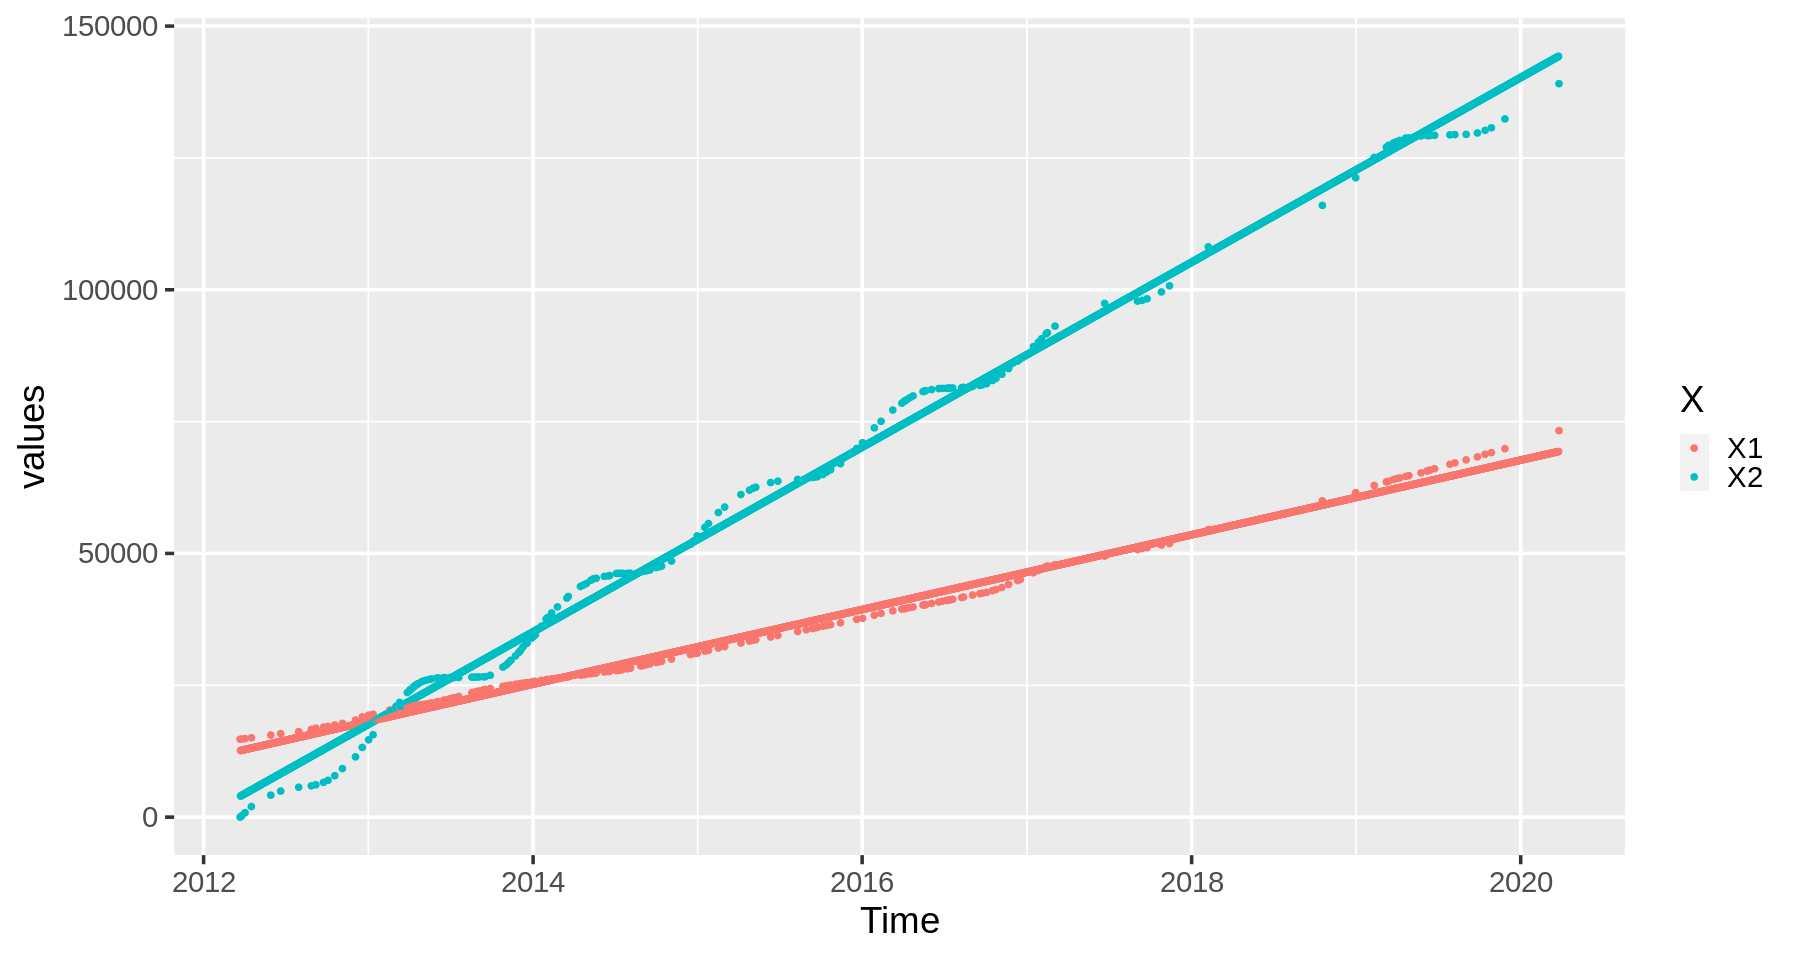

In [5]:
df_intp %>% 
    pivot_longer(-Time, names_to = 'X', values_to = 'values')  %>%
    ggplot(aes(x = Time, y = values, color = X)) +
    geom_point() +
    theme_grey(base_size = 22)